# Перцептрон для восприятия цифр

В этом задании вам предстоит реализовать классический перцептрон, немного улчшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [1]:
import sys

import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
from typing import NoReturn

In [2]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")

    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций.

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [213]:
class Perceptron:
    def __init__(self, iterations: int = 100):
        """
        Parameters
        ----------
        iterations : int
        Количество итераций обучения перцептрона.

        Attributes
        ----------
        w : np.ndarray
        Веса перцептрона размерности X.shape[1] + 1 (X --- данные для обучения),
        w[0] должен соответстовать константе,
        w[1:] - коэффициентам компонент элемента X.

        Notes
        -----
        Вы можете добавлять свои поля в класс.

        """

        self.w = None
        self.fst = None
        self.snd = None
        self.n = iterations
        self.inc = 1
        self.dec = -1

    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Обучает простой перцептрон.
        Для этого сначала инициализирует веса перцептрона,
        а затем обновляет их в течении iterations итераций.

        Parameters
        ----------
        X : np.ndarray
            Набор данных, на котором обучается перцептрон.
        y: np.ndarray
            Набор меток классов для данных.

        """
        self.w = [0] * (X.shape[1] + 1)
        (self.fst, self.snd) = np.unique(y)
        for j in range(self.n):

            for i in range(len(X)):
                cur_sum = self.w[0]

                for xi in range(1, len(X[i]) + 1):
                    xe = X[i][xi - 1]
                    cur_sum += self.w[xi] * xe

                if y[i] != ((self.fst, self.snd)[bool(cur_sum < 0)]):
                    for wi in range(len(self.w)):
                        self.w[wi] += (self.inc if y[i] == self.fst else self.dec) *\
                                      (1 if wi == 0 else X[i][wi - 1])

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает метки классов.

        Parameters
        ----------
        X : np.ndarray
            Набор данных, для которого необходимо вернуть метки классов.

        Return
        ------
        labels : np.ndarray
            Вектор индексов классов
            (по одной метке для каждого элемента из X).

        """
        ans = []
        for x in X:
            cur_sum = self.w[0]
            for xi in range(len(x)):
                cur_sum += self.w[xi + 1] * x[xi]
            ans.append((self.fst, self.snd)[bool(cur_sum < 0)])
        return ans


Посмотрим на то, как наш перцептрон справляется с различными наборами данных

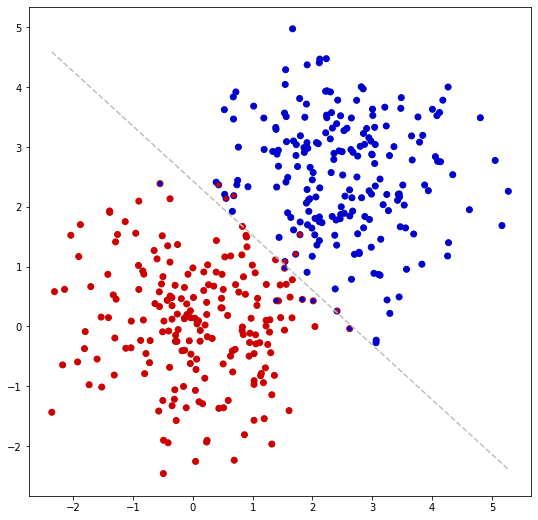

In [214]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

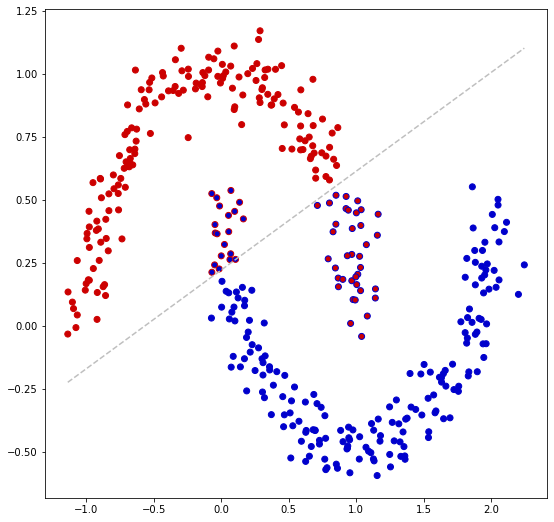

In [215]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса.

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [233]:
class PerceptronBest(Perceptron):

    def __init__(self, iterations: int = 100):
        """
        Parameters
        ----------
        iterations : int
        Количество итераций обучения перцептрона.

        Attributes
        ----------
        w : np.ndarray
        Веса перцептрона размерности X.shape[1] + 1 (X --- данные для обучения),
        w[0] должен соответстовать константе,
        w[1:] - коэффициентам компонент элемента X.

        Notes
        -----
        Вы можете добавлять свои поля в класс.

        """

        super().__init__(iterations)

    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Обучает перцептрон.

        Для этого сначала инициализирует веса перцептрона,
        а затем обновляет их в течении iterations итераций.

        При этом в конце обучения оставляет веса,
        при которых значение accuracy было наибольшим.

        Parameters
        ----------
        X : np.ndarray
            Набор данных, на котором обучается перцептрон.
        y: np.ndarray
            Набор меток классов для данных.

        """
        self.w = [0] * (X.shape[1] + 1)
        (self.fst, self.snd) = np.unique(y)
        min_err = float('inf')
        nw = []
        nw[:] = self.w
        for j in range(self.n):
            en = 0
            for i in range(len(X)):
                cur_sum = self.w[0]

                for xi in range(1, len(X[i]) + 1):
                    xe = X[i][xi - 1]
                    cur_sum += self.w[xi] * xe

                if y[i] != ((self.fst, self.snd)[bool(cur_sum < 0)]):
                    en += 1
                    for wi in range(len(self.w)):
                        self.w[wi] += (self.inc if y[i] == self.fst else self.dec) *\
                                      (1 if wi == 0 else X[i][wi - 1])
            if en < min_err:
                min_err = en
                nw[:] = self.w
        self.w[:] = nw
        # print(self.w)

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

[6, -2.4023029704421033, -4.577816862657653]
[7, -2.3642612133122864, -2.286207092091777]
[8, -1.8787096160242882, -2.4794927126171666]
[9, -2.737993972476517, -2.144347505538068]
[10, -1.7396766295988342, -3.9425952994202156]
end  [10, -1.7396766295988342, -3.9425952994202156]


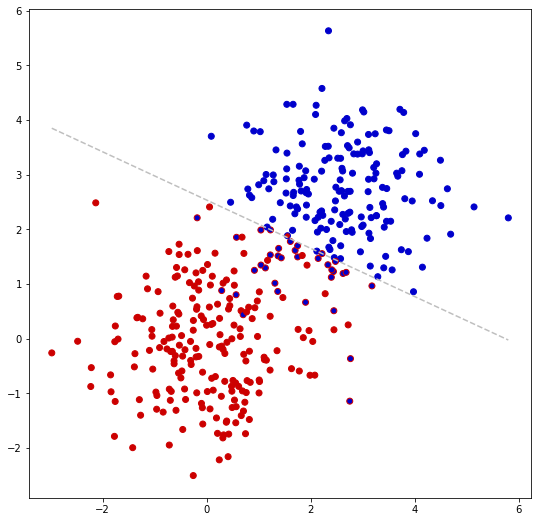

In [225]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

[0, -0.7064742894333004, 3.9414364394165275]
[0, -0.5085182728664928, 4.087172353989214]
[0, -0.7340397414159121, 4.366563307421438]
[0, -0.5543696484686527, 3.9030857563032293]
end  [0, -0.5543696484686527, 3.9030857563032293]


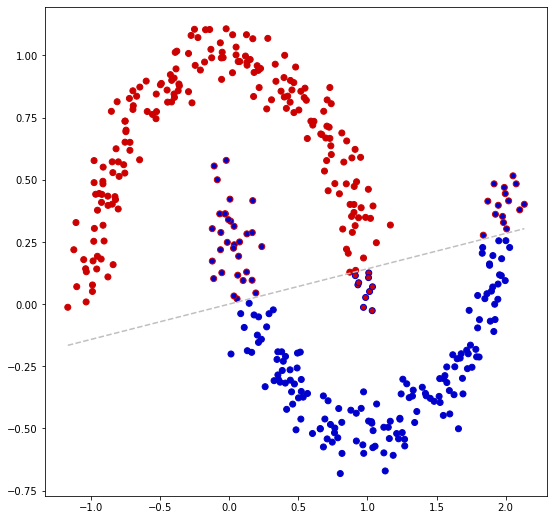

In [226]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)